<html>
    <div style="padding: 50px; background-color: lightskyblue; text-align: center; color: #000;">
        <h1>CAB420 Workshop - Week 9 Practical</h1>
        <h2>Multi-Task and Semi Supervised Learning</h2>
    </div>
</html>

# Problem 1: Face Recognition with an AutoEncoder
The Semi Supervised Learning lecture example (CAB420_Encoders_and_Decoders_Example_3_Semi_Supervised_Learning.ipynb) uses a network which is an autoencoder, with a class-based output also included, and resulting from a couple of dense layers connected to the bottleneck. This network allows the autoencoder to class specific information, as the bottleneck layer must be useful for both reconstruction and classification. 

Extend this idea to face recognition. In doing so, you should:
1. Use the YaleB dataset to train the model. Look at the Week 7 practical solutions for code to prepare YaleB (and other face recognition datasets) for use in a DCNN
2. Modify the class-based output of the network to classify the face into the target identities
3. Use the trained network to extract bottleneck features and train a simple classifier (i.e. a CKNN) for face recognition. Feel free to reuse code from earlier weeks (i.e. the week 7 practical solution) to achieve this.
4. Evaluate the same network on the ORL and Yale face datasets. Consider how well the network trained on YaleB generalises to these other datasets and compare this to the results observed in previous practicals that have dealt with this data (Week 6 and 7)

In [6]:
import os

import keras
from keras.datasets import fashion_mnist
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.utils import to_categorical, plot_model
from keras.models import Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

import numpy as np
import scipy.io

from sklearn.manifold import TSNE

In [4]:
yale_b = scipy.io.loadmat('data/YaleB_32x32.mat')
features = yale_b['fea'] / 255.0
gnd = np.array(yale_b['gnd'])

test_frames = np.array(()).astype('int')

for i in np.unique(gnd):
    indexes = np.where(gnd == i)[0]
    count = len(indexes)

    f = np.random.randint(count, size = 6)
    test_frames = np.append(test_frames, indexes[f])

gnd = keras.utils.to_categorical(gnd)
train_features = features
train_gnd = gnd

train_features = np.delete(train_features, test_frames, 0)
train_gnd = np.delete(train_gnd, test_frames, 0)

test_features = features[test_frames, :]
test_gnd = gnd[test_frames, :]

train_features_reshape = np.reshape(train_features.transpose(), (32, 32, 1, len(train_features)))
train_features_reshape = np.transpose(train_features_reshape, (3, 1, 0, 2))
test_features_reshape = np.reshape(test_features.transpose(), (32, 32, 1, len(test_features)))
test_features_reshape = np.transpose(test_features_reshape, (3, 1, 0, 2))

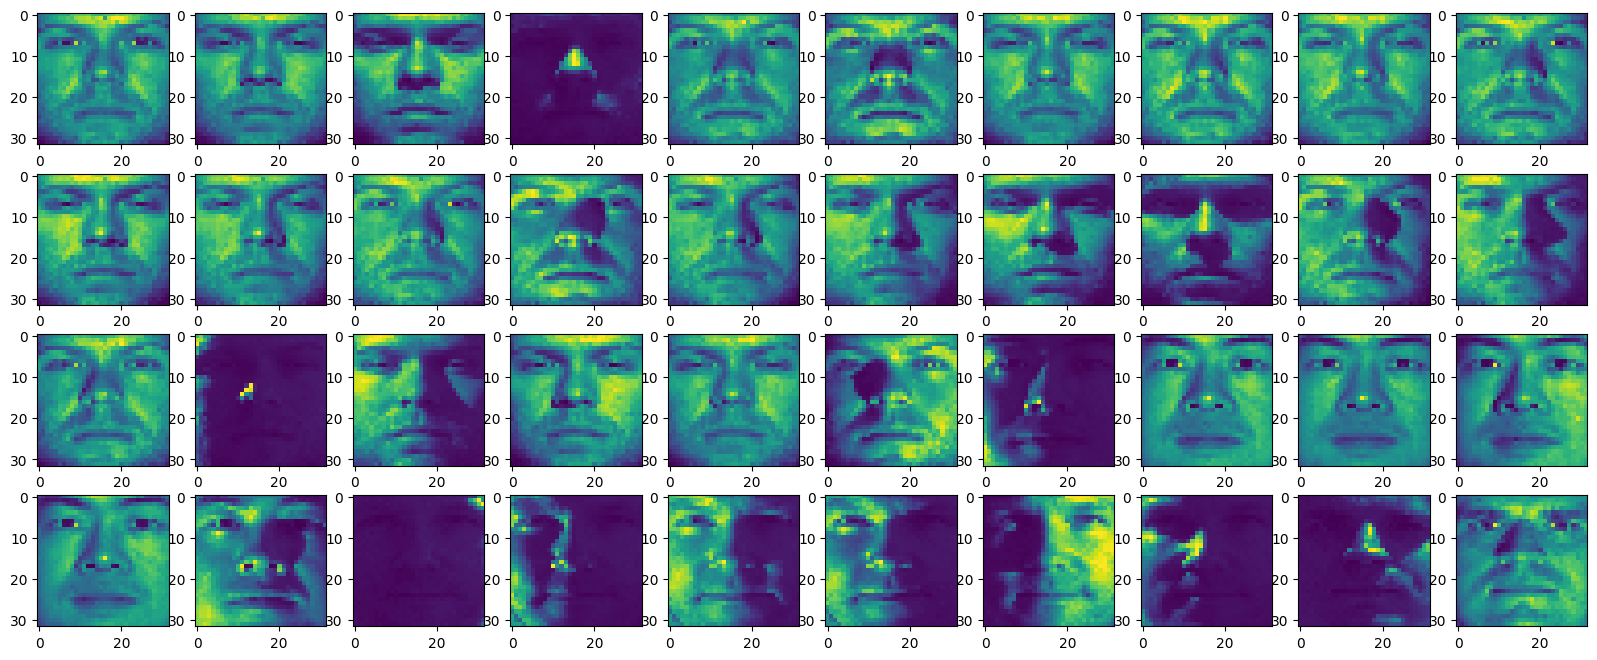

In [5]:
fig = plt.figure(figsize = [20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_features_reshape[i, :, :, 0])

for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_features_reshape[i, :, :, 0])

In [8]:
encoding_dim = 64

In [ ]:
input = Input(shape = (1024, ))
encoded = Dense(encoding_dim * 4, activation = 'relu')(input)
encoded = Dense(encoding_dim * 2, activation = 'relu')(encoded)
encoded = Dense(encoding_dim, activation = 'relu')(encoded)

decoded = Dense(encoding_dim * 2, activation = 'relu')(encoded)
decoded = Dense(encoding_dim * 4, activation = 'relu')(decoded)
decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input, decoded)
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', jit_compile = False)
print(autoencoder.summary())
plot_model(autoencoder, show_shapes = True, dpi = 60)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,944 (1.85 MB)

 Trainable params: 484,944 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [10]:
history = autoencoder.fit(train_features, train_gnd,
                          epochs = 100, 
                          batch_size = 256,
                          shuffle = True, 
                          validation_data = (test_features, test_gnd), verbose = False)

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 784), found shape=(None, 1024)

# Problem 2. Multi Task Learning with Siamese Networks 
Siamese networks can also be configured for multi-task learning. There are many ways to do this, but a common way is to consider a secondary task on one of the inputs. Using the Week 7 practical solution as a startig point, add a second task to the network. Possible tasks include:
- a classification output, which uses the embedding from one image (such as the anchor image) to classify the face into the identity using a softmax output
- an image output that adds a decoder to the embedding to try and reconstruct the original image 

For both of these, you may also wish to consider appropriate loss weights. Any selection of loss weights should consider both the importance of the tasks, and also the scale of the losses (i.e. are both losses typically in the same range? Or is one much larger or smaller than the other?).

Using the modified network, evaluate the face recognition performance on YaleB, ORL and Yale. As with Question 1, use a simple classifier and feel free to borrow from code such as the week 7 practical solutions. Compare the generalisation ability of the multi task network to the original single task network